In [1]:
#! pip install fairlearn
#https://fairlearn.github.io/api_reference/index.html

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from shap.datasets import adult  # shap is only used its dataset utility
adult()[0].head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [4]:
#If the person is elegable for a loan
pd.DataFrame(adult()[1]).head(10)

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,True
8,True
9,True


In [5]:
#Look at the function definition
import inspect
print(inspect.getsource(adult))

def adult(display=False):
    """ Return the Adult census data in a nice package. """
    dtypes = [
        ("Age", "float32"), ("Workclass", "category"), ("fnlwgt", "float32"),
        ("Education", "category"), ("Education-Num", "float32"), ("Marital Status", "category"),
        ("Occupation", "category"), ("Relationship", "category"), ("Race", "category"),
        ("Sex", "category"), ("Capital Gain", "float32"), ("Capital Loss", "float32"),
        ("Hours per week", "float32"), ("Country", "category"), ("Target", "category")
    ]
    raw_data = pd.read_csv(
        cache(github_data_url + "adult.data"),
        names=[d[0] for d in dtypes],
        na_values="?",
        dtype=dict(dtypes)
    )
    data = raw_data.drop(["Education"], axis=1)  # redundant with Education-Num
    filt_dtypes = list(filter(lambda x: not (x[0] in ["Target", "Education"]), dtypes))
    data["Target"] = data["Target"] == " >50K"
    rcode = {
        "Not-in-family": 0,
        "Unmarried": 1,
      

In [6]:
X_raw, y_true = adult(display=True) #Raw dataset
X_raw.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


## We do not want sex or race affecting the model so we remove them to avoid any bias

In [7]:
X_raw, y_true = adult(display=False) #Factorize the cats
#'remove 'Sex' and 'Race' from the model so they do not cause bias 
X = X_raw.drop(labels=['Sex','Race'], axis=1)

X.head()


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,0.0,0.0,40.0,5


In [8]:
#Convert y to binary 1 or 0
y_true = y_true * 1 #convert y to bianry numeric
pd.DataFrame(y_true).head(3)

,0
0,0
1,0
2,0


### Train a model

In [9]:
#! pip install fairlearn

In [10]:
#from fairlearn.metrics import group_summary
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

#Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=1) # 70% training and 30% test

#Train a tree
classifier = DecisionTreeClassifier()
classifier.fit(X, y_true)

#Run the predictions
y_pred = classifier.predict(X)

#See the accuracy
metrics.accuracy_score(y_true, y_pred)

0.972881668253432

In [11]:
#!pip install --upgrade scikit-learn
import sklearn
print(sklearn.__version__)

0.22.2.post1


[[24585   135]
 [  748  7093]]


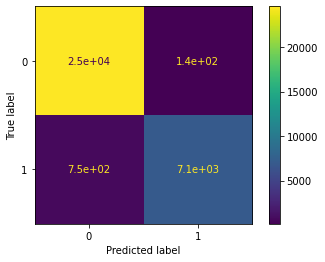

In [12]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(y_true, y_pred))
plot_confusion_matrix(classifier, X, y_true)


## Bring the sex column into a dataset so we can leter check any bias that has worked its way into the dataset 

In [13]:
sex = X_raw['Sex'].apply(lambda sex: "female" if sex == 0 else "male") #convert sex to male/female
pd.DataFrame(sex).head()

,Sex
0,male
1,male
2,male
3,male
4,female


## We can see in the original data we had more males then females 

<BarContainer object of 2 artists>

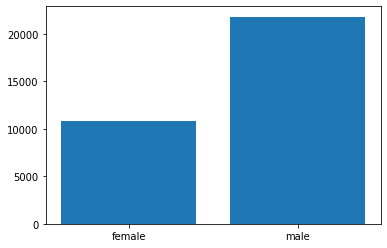

In [14]:
import matplotlib.pyplot as plt
dfgroup = pd.DataFrame(sex).groupby(['Sex'])['Sex'].count()
plt.bar(['female','male'], dfgroup)

In [15]:
#print('Accuracy of the model between females and males')
#group_summary(accuracy_score, y_true, y_pred, sensitive_features=sex)

#Model has greater accuracy for females
#'female': 0.9958221149382601, 'male': 0.9668196420376319

In [16]:
#from fairlearn.metrics import selection_rate_group_summary
##Percent of data points marked as True 
#print('female and male chance of getting a loan')
#selection_rate_group_summary(y_true, y_pred, sensitive_features=sex)
##Males have a higher percentage chance of getting a loan
##'female': 0.1065824900194968, 'male': 0.28347865993575033
##Bias in previous loans entering the model

## Fairlearn Dashboard

In [17]:
# jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [18]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sex,
                       sensitive_feature_names=['sex'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

## /\ is the disparity on who will get a loan a problem? We will need ot look at explinations to understand more about the model

# Show with regression

In [19]:
regressionageX = X
age = regressionageX['Age']
regressionageX = regressionageX.drop(labels=['Age'], axis=1)

[171.20521926]
0.07981732650532813


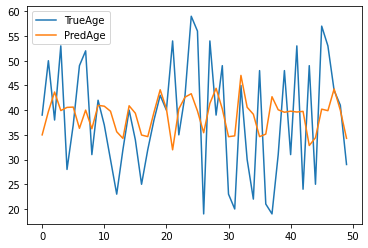

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

#Train
clin = LinearRegression()
clin.fit(regressionageX, age)

#Run the predictions
y_age_pred = clin.predict(regressionageX)

#See the accuracy
#metrics.accuracy_score(y_true, y_pred)

print(mean_squared_error(age, y_age_pred, multioutput='raw_values'))
print(r2_score(age, y_age_pred))

fig = plt.figure()
ax = plt.axes()

ax.plot(age.head(50), label = "TrueAge")
ax.plot(pd.DataFrame(y_age_pred).head(50), label = "PredAge")
plt.legend()

[<matplotlib.lines.Line2D at 0x7fd4b53c5860>]

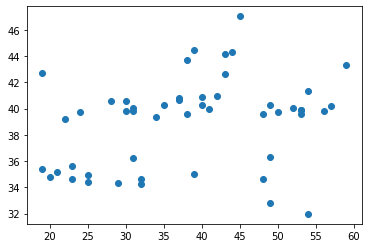

In [21]:
#Actual vs predicted
fig = plt.figure()
ax = plt.axes()
ax.plot(age.head(50), pd.DataFrame(y_age_pred).head(50), 'o')

In [22]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sex.head(500),
                       sensitive_feature_names=['sex'],
                       y_true=age.head(500),
                       y_pred={"initial model": pd.DataFrame(y_age_pred).head(500)})

FairlearnWidget(value={'true_y': [39.0, 50.0, 38.0, 53.0, 28.0, 37.0, 49.0, 52.0, 31.0, 42.0, 37.0, 30.0, 23.0…

## Add more features to investigate (race)

In [23]:
#Get the race details
Xrace, delme = adult(display=True) #Raw dataset
Xrace = Xrace[['Race']]
Xrace

,Race
0,White
1,White
2,White
3,Black
4,Black
...,...
32556,White
32557,White
32558,White
32559,White


In [24]:
from fairlearn.metrics import group_summary, selection_rate_group_summary

In [25]:
#Accuracy by race
group_summary(accuracy_score, y_true, y_pred, sensitive_features=Xrace)

{'overall': 0.972881668253432,
 'by_group': {' Amer-Indian-Eskimo': 0.9903536977491961,
  ' Asian-Pac-Islander': 0.9932627526467758,
  ' Black': 0.984955185659411,
  ' Other': 0.992619926199262,
  ' White': 0.9703767615760713}}

In [26]:
#Percentage of by race
selection_rate_group_summary(y_true, y_pred, sensitive_features=Xrace)

{'overall': 0.22198335431958477,
 'by_group': {' Amer-Indian-Eskimo': 0.11254019292604502,
  ' Asian-Pac-Islander': 0.2627526467757459,
  ' Black': 0.11331626120358515,
  ' Other': 0.09225092250922509,
  ' White': 0.2351524302559678}}

In [27]:
#Put sex and reace into one dataframe
sexrace = pd.concat([sex, Xrace], axis=1)

In [28]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sexrace,
                       sensitive_feature_names=['sex', 'race'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

# Run the mitigator to get a less bias model

In [29]:
%%time
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, GridSearch
constraint = DemographicParity()
classifier = DecisionTreeClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
selection_rate_group_summary(y_true, y_pred_mitigated, sensitive_features=sex)

CPU times: user 1min 10s, sys: 324 ms, total: 1min 10s
Wall time: 2min 24s


{'overall': 0.2632597278953349,
 'by_group': {'female': 0.2544796212050877, 'male': 0.2675998164295548}}

In [30]:
#View the results
FairlearnDashboard(sensitive_features=sex,
                       sensitive_feature_names=['sex'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred, "mitigated model": y_pred_mitigated})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

## Create some more models

In [31]:
%%time
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, GridSearch
mitigatorExponentiatedGradient = ExponentiatedGradient(DecisionTreeClassifier(), DemographicParity())
mitigatorExponentiatedGradient.fit(X, y_true, sensitive_features=sex)
y_pred_mitigatedExponentiatedGradient = mitigatorExponentiatedGradient.predict(X)

CPU times: user 1min 10s, sys: 69.2 ms, total: 1min 10s
Wall time: 2min 23s


In [32]:
%%time
mitigatorGridSearch = GridSearch(DecisionTreeClassifier(), DemographicParity())
mitigatorGridSearch.fit(X, y_true, sensitive_features=sex)
y_pred_mitigatedGridSearch = mitigatorGridSearch.predict(X)

CPU times: user 27 s, sys: 435 ms, total: 27.4 s
Wall time: 55.8 s


In [33]:
#Create a basic logistic regression model 
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver='liblinear', fit_intercept=True)
lg.fit(X, y_true)
y_pred_lg = lg.predict(X)

In [34]:
%%time
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=500)
clf.fit(X, y_true)
y_pred_MLP = clf.predict(X)

CPU times: user 7.44 s, sys: 11.8 ms, total: 7.45 s
Wall time: 15.1 s


In [35]:
FairlearnDashboard(sensitive_features=sex,
                       sensitive_feature_names=['sex'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred, "mitigated model Exponentiated Gradient": y_pred_mitigatedExponentiatedGradient, "Logistic Regression": y_pred_lg, "NN": y_pred_MLP})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…